In [1]:
# !pip install -q torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(seed)
       torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seed(42)

<h1>1. Download and Extract the Dataset</h1>

In [4]:
# !wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

<h1>2. Dataset and Training Configuration Parameters</h1>

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    batch_size: int = 32
    num_epochs: int  = 100
    learning_rate: float = 1e-4
    
    log_interval: int = 1
    test_interval: int = 1
    data_root: str = "./"
    
    num_workers: int = 5
    device: str = "cuda"

training_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cpu


<h3>2.1. Load Custom Datasets in PyTorch</h3>

In [6]:
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join("10_Monkey_Species", "validation", "validation")

In [7]:
df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df["Latin Name"].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


<h1>3. Dataset Preprocessing</h1>

In [8]:
# mean and std of this Monkey Species Dataset
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

img_size = (244, 224)

preprocess = transforms.Compose([
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor()
])

common_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean=mean, std=std)
])

train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    # the goal is to make training result is more robust because we random erasing some pixel and 
    # make it like human that can recognize image while some of pixel are missing.
    transforms.RandomErasing(p=0.4), 
    transforms.RandomApply([
        # this algorithm is a collection of transformation to translate, rotate, and scale image
        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
    ], p=0.1),
    transforms.Normalize(mean=mean, std=std)
])

<h3>3.1. DataLoaders Preparation</h3>

In [9]:
train_data = datasets.ImageFolder(root=train_root, transform=train_transforms)
val_data = datasets.ImageFolder(root=val_root, transform=common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [10]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [11]:
len(train_data), len(val_data)

(1097, 272)

In [12]:
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=training_config.batch_size,
    num_workers=training_config.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle=False,
    batch_size=training_config.batch_size,
    num_workers=training_config.num_workers
)

In [13]:
len(next(iter(train_loader)))

2

In [14]:
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [15]:
class_mapping = {i: name.strip() for i, name in enumerate(df[1:]['Latin Name'])}
class_mapping
    

{0: 'alouatta_palliata',
 1: 'erythrocebus_patas',
 2: 'cacajao_calvus',
 3: 'macaca_fuscata',
 4: 'cebuella_pygmea',
 5: 'cebus_capucinus',
 6: 'mico_argentatus',
 7: 'saimiri_sciureus',
 8: 'aotus_nigriceps',
 9: 'trachypithecus_johnii'}

<h3>3.2. Display Sample Images from the Dataset</h3>

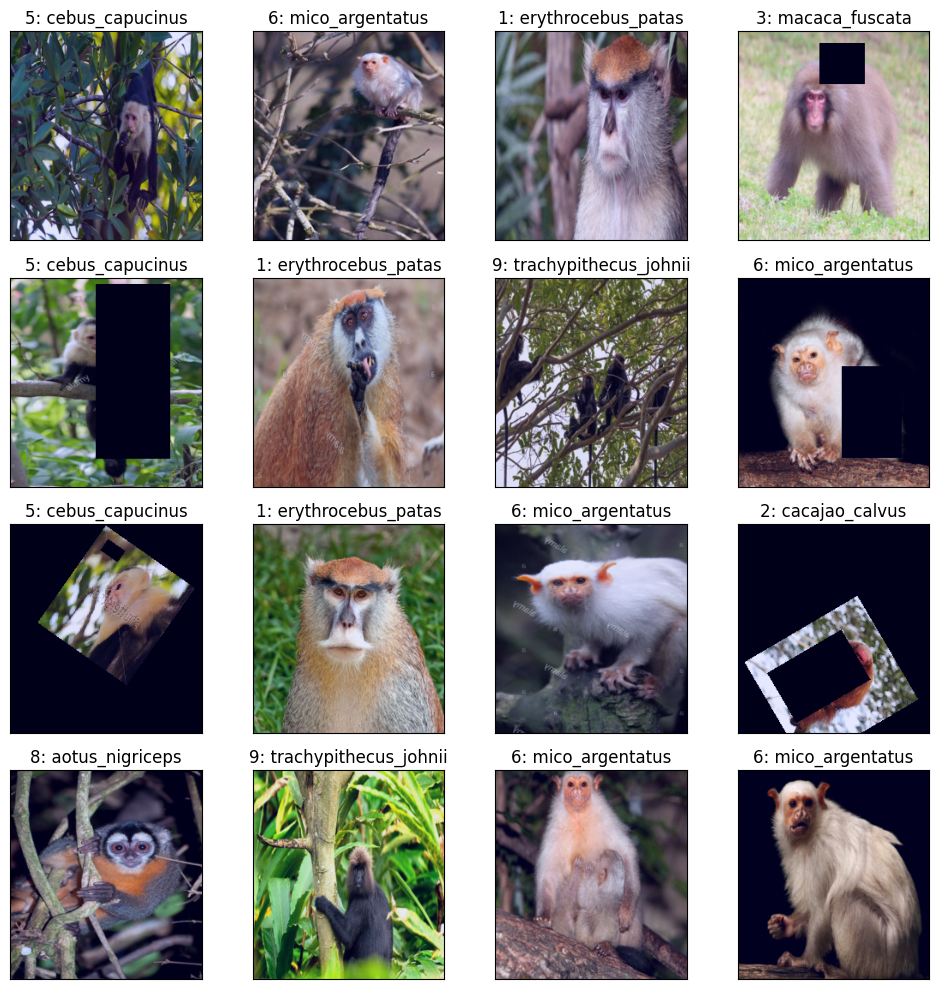

In [16]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10, 10))
    
    images, labels = next(iter(dataloader))
    
    num_rows = 4
    num_cols = int(np.ceil(num_images/num_rows))
    
    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        image = image.permute(1, 2, 0)
        
        # Normalize image
        image = (image - image.min()) / (image.max()-image.min())
        ax.imshow(image, cmap="gray")
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")
    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

<h1>4. CNN Model Implementation in PyTorch</h1>

In [17]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self._model = nn.Sequential(
            #------------------------------ Convolution Layers ------------------------------ 
            
            #--------------------------------------------------------------------------------
            # Conv2d Norm Activation Block1: 32 Filters, MaxPool.
            #--------------------------------------------------------------------------------
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= 2),
            
            #--------------------------------------------------------------------------------
            # Conv2d Norm Activation Block2: 64, 128 Filters, MaxPool, Dropout(p=0.25)
            #--------------------------------------------------------------------------------
            # using LazzyConv2d to set in_channel automatically based on prev layer
            nn.LazyConv2d(out_channels = 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),

            nn.LazyConv2d(out_channels = 128, kernel_size = 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
            
            #--------------------------------------------------------------------------------
            # Conv2d Norm Activation Block3: 128, 256, 512, Filters, MaxPool
            #--------------------------------------------------------------------------------
            # Conv2dNormActivation is equal to Conv2D + BatchNorm2d + ReLU
            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3),
            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            
            #----------------------------- Feed Forward Layers ------------------------------
            # AdavptiveAvgPool2d use when we don't care about the input size
            nn.AdaptiveAvgPool2d(output_size=(3, 3)),
            
            #--------------------------------------------------------------------------------
            # Flatten the confolutional features.
            #--------------------------------------------------------------------------------
            nn.Flatten(),
            
            #--------------------------------------------------------------------------------
            # Classification Head.
            #--------------------------------------------------------------------------------
            nn.Linear(in_features=512*3*3, out_features=256),
            nn.Linear(in_features=256, out_features=10)
        )
    
    def forward(self, x):
        return self._model(x)
        

In [ ]:
model = MyModel()

optimizer = Adam(model.parameters(), lr=training_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
logdir = "runs/80epochs-3.3M_param_dropout"
writer = SummaryWriter(logdir)
dummy_input = (1, 3, 224, 224)
print(summary(model, dummy_input, row_settings=["var_names"], device="cpu"))

Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


device(type='mps')

<h1>5. Model Training and Evaluation</h1>

In [ ]:
# The training process will update all paramaters (in feature extraction at convolution steps and in full connected neural network) to minimze the error
def train(model, train_loader):
    model.train()
    model.to(DEVICE)
    
    running_loss = 0
    correct_prediction = 0
    total_train_samples = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_prediction += (predicted == labels).sum().item()
    
    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_prediction / total_train_samples
    return train_avg_loss, train_accuracy

In [32]:
def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0
    
    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
        
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()
    
    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples
    return val_avg_loss, val_accuracy
        

In [ ]:
def main(model, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_acc = 0.0
    best_weights = None
    
    for epoch in range(training_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1:0>2}/{training_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Logging metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model....")
            torch.save(best_weights, "best.pt")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [36]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Training:   0%|          | 0/35 [00:03<?, ?it/s]


RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes. Non-divisible input sizes are not implemented on MPS device yet. For now, you can manually transfer tensor to cpu in this case. Please refer to [this issue](https://github.com/pytorch/pytorch/issues/96056)

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, training_config.num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, training_config.num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, training_config.num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, training_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<h1>6. Saving and Loading Best Model Weights</h1>

In [ ]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

MyModel(
  (_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1,

<h1>7. Inference</h1>

In [ ]:
def prediction(model, val_loader):
    model.eval()
    model.to(DEVICE)
    
    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []
    
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
        
        prob = F.softmax(outputs, dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]
        
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())
        
    return(torch.cat(all_images).numpy(),
           torch.cat(all_labels).numpy(),
           torch.cat(all_pred_indices).numpy(),
           torch.cat(all_pred_probs).numpy(),)

In [ ]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return np.clip(image, 0, 1)

In [ ]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=5):
    fig = plt.figure(figsize=(20, 5))
    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)
        image = sample_images[idx].transpose(1, 2, 0)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)
        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis("off")
    
    plt.show()
    

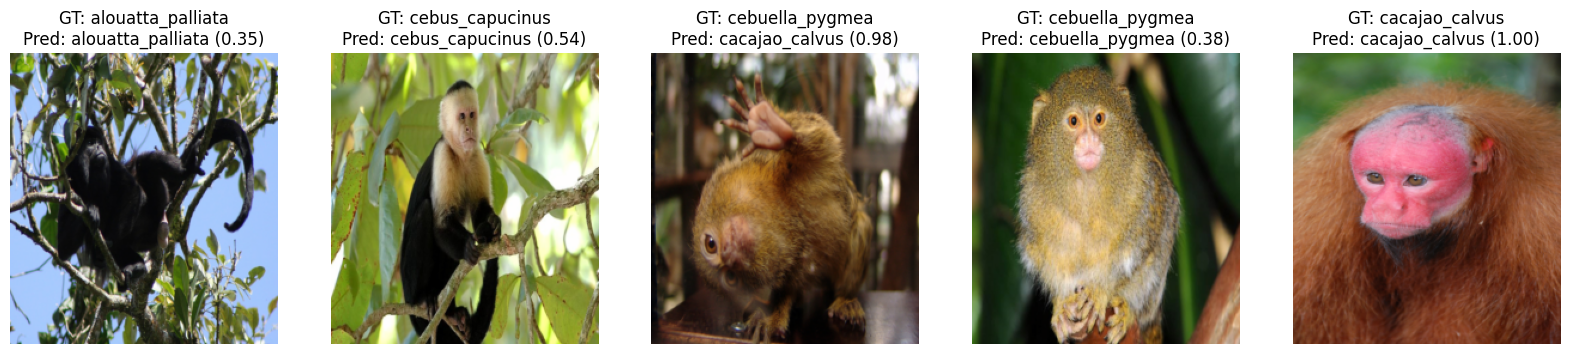

In [ ]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

<h3>7.1. Confusion Matrix</h3>

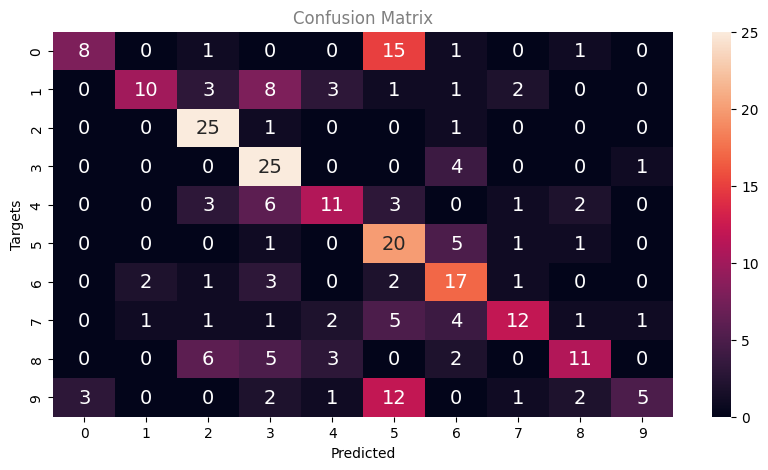

In [ ]:
cm = confusion_matrix(y_true=val_gt_labels, y_pred=pred_indices)
plt.figure(figsize=[10, 5])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()